In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import json
import signature.tensor_algebra as ta
from signature.pricing.models.sig_vol import SigVol, jit_char_func, jit_riccati_func
from pricing.products.vanilla_option import VanillaOption
from pricing.models.model_params import LewisParams, MCParams
from pricing.utility import from_1_delta_call_to_strike

green = "#5b6c64"
copper = "#B56246"

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
N = 5
e = ta.AlgebraBasis(dim=2, trunc=2 * N)

In [127]:
%%time
shuffle_table = ta.get_shuffle_table(table_trunc=2 * N, dim=2)

CPU times: total: 1.11 s
Wall time: 1.71 s


## Plotting

In [4]:
T = 1
F0 = 100
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)

k = np.log(K / F0)

In [5]:
def plot_smiles(filename, ax, N, rho):
    with open(filename, 'r') as file:
        iv_dict = json.load(file)

    ax.plot(k, iv_dict["call"]["price"], "--", color=green,  label="Call")
    ax.fill_between(k, iv_dict["call"]["lower"], iv_dict["call"]["upper"], color=green, alpha=0.2)
    ax.plot(k, iv_dict["put"]["price"], color=copper, label="Put")
    ax.fill_between(k, iv_dict["put"]["lower"], iv_dict["put"]["upper"], color=copper, alpha=0.2)
    ax.grid()
    # ax.legend()
    ax.set_xlabel(r"$\log(K / S_0)$")
    ax.set_title(r"$N = $" + str(N) + r",  $\rho = $" + str(rho))


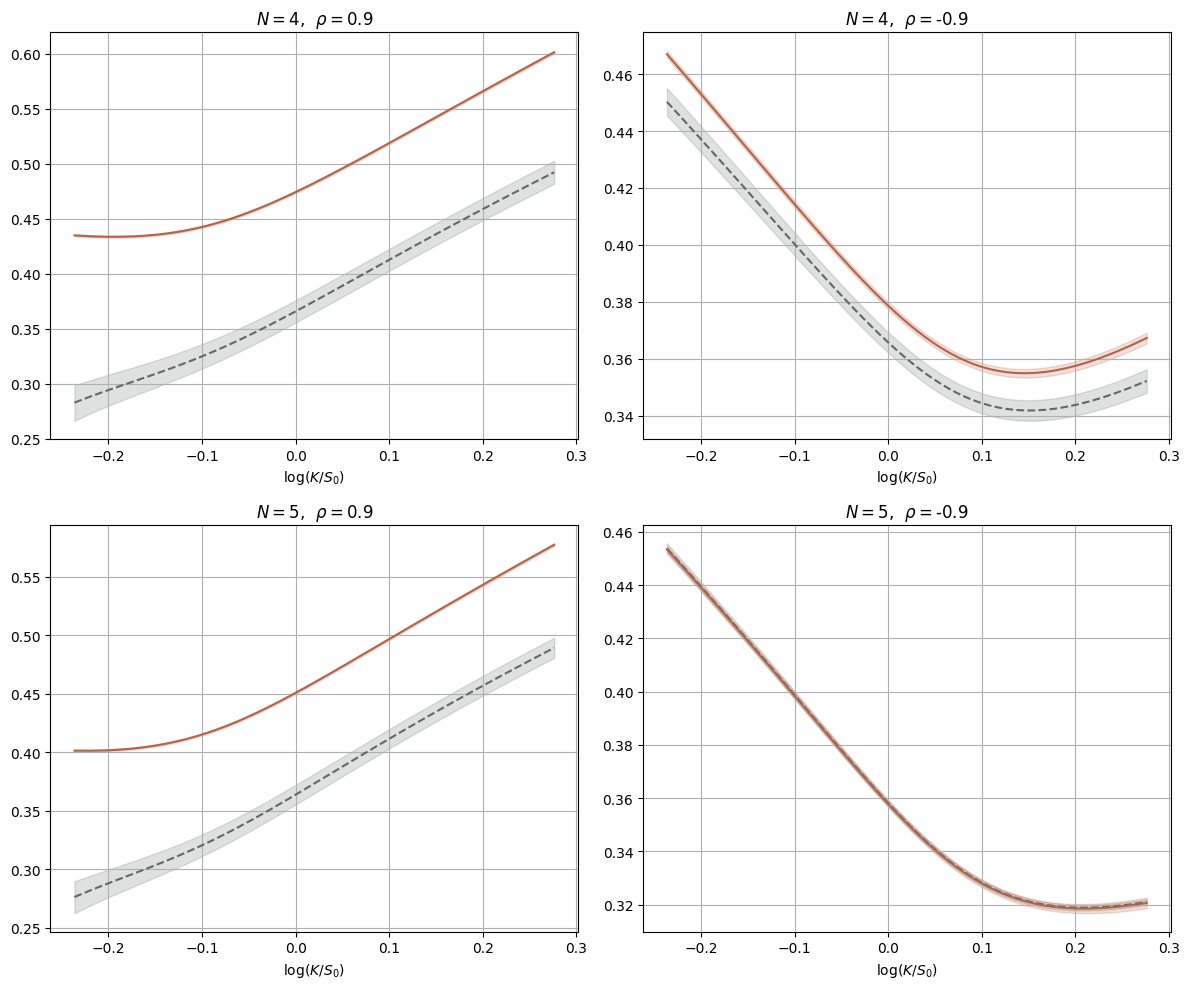

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4)

lead_str = "_lead1"

plot_smiles(filename='martingality_results/smiles_N4_rho_pos' + lead_str + '.json', ax=ax[0, 0], N=4, rho=0.9)
plot_smiles(filename='martingality_results/smiles_N4_rho_neg' + lead_str + '.json', ax=ax[0, 1], N=4, rho=-0.9)
plot_smiles(filename='martingality_results/smiles_N5_rho_pos' + lead_str + '.json', ax=ax[1, 0], N=5, rho=0.9)
plot_smiles(filename='martingality_results/smiles_N5_rho_neg' + lead_str + '.json', ax=ax[1, 1], N=5, rho=-0.9)

fig.tight_layout()
fig.savefig("martingality_results/sig_smiles_1.pdf", format="pdf", transparent=True)

In [8]:
leading_coef = 1

## Strict local martingale

In [32]:
N = 4
rho = -0.9

rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  1.  ])

In [35]:
vol_ts = ta.from_array(trunc=2 * N, array=arr, dim=2)
model = SigVol(vol_ts=vol_ts, rho=rho, shuffle_table=shuffle_table)
print(model.vol_ts)

0.27*0 + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + -0.06*222 + -0.27*1111 + 0.05*1112 + -0.44*1121 + 0.33*1122 + 0.13*1211 + 0.26*1212 + -0.15*1221 + 0.47*1222 + 0.39*2111 + 0.28*2112 + -0.31*2121 + -0.03*2122 + -0.46*2211 + -0.35*2212 + 0.18*2221 + 1.0*2222


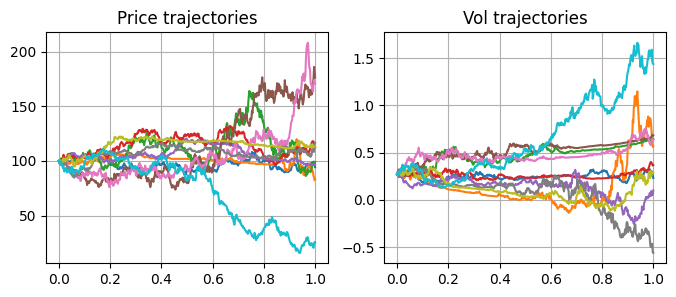

In [36]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [37]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

[0.47433673 0.46283298 0.46058434 0.46213686 0.46132088 0.45582867
 0.44710777 0.43820191 0.43165859 0.4284497  0.42795315 0.4285927
 0.42865685 0.42694983 0.42311209 0.41759967 0.41141126 0.40569827
 0.40139179 0.39894633 0.39824914 0.39869507 0.39938782 0.39940542
 0.39805918 0.39508146 0.39069676 0.38555996 0.38057763 0.37665611
 0.37443854 0.37409826 0.3752494  0.37701448 0.37825359 0.37791329
 0.37540744 0.37091085 0.36544354 0.36065436 0.3582805  0.35937273
 0.36354798 0.36870334 0.37163126 0.36967517 0.36298232 0.35609708
 0.35658286 0.36814944]
CPU times: total: 15.2 s
Wall time: 37.2 s


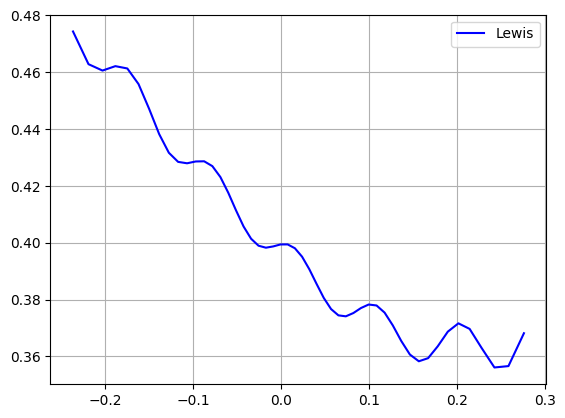

In [38]:
%%time
smile_cf = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True,
                                 pricing_params=LewisParams(cf_timestep=0.001))

print(smile_cf)

fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf, "b", label="Lewis")
ax.grid()
ax.legend()

In [37]:
%%time
smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.21s/it]

CPU times: total: 7min 16s
Wall time: 13min 48s


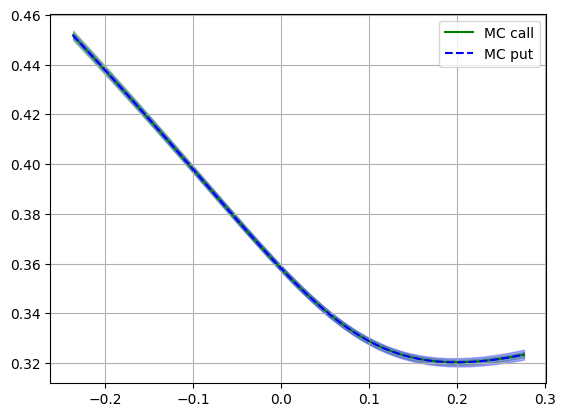

In [39]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [40]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N4_rho_neg' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## True martingale

In [9]:
leading_coef = 1

In [10]:
N = 3
rho = -0.9

rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
vol_ts = ta.from_array(trunc=2 * N, array=arr, dim=2)
print(vol_ts)

0.27*0 + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + 1.0*222


In [12]:
model = SigVol(vol_ts=vol_ts, rho=rho, shuffle_table=shuffle_table)

In [13]:
print(model.vol_ts)

0.27*0 + -0.06*1 + 0.36*2 + 0.2*11 + -0.41*12 + 0.48*21 + 0.26*22 + 0.29*111 + -0.37*112 + -0.05*121 + -0.13*122 + 0.43*211 + 0.14*212 + 0.32*221 + 1.0*222


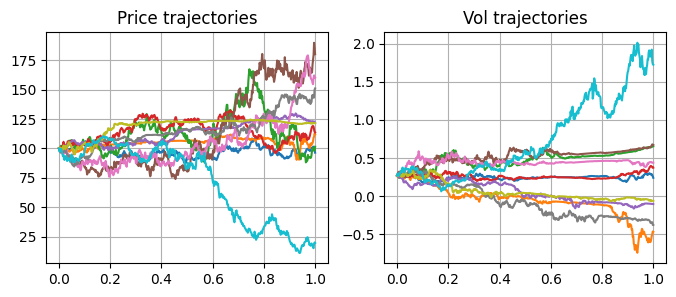

In [14]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [15]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

[0.50574641 0.49891319 0.49276687 0.48707881 0.48169862 0.47653775
 0.47155235 0.46672788 0.46206641 0.45757698 0.45326876 0.44914667
 0.445209   0.44144656 0.43784296 0.43437566 0.43101742 0.42773809
 0.42450632 0.42129127 0.41806415 0.41479951 0.4114763  0.40807867
 0.40459648 0.40102556 0.39736772 0.3936305  0.38982676 0.38597403
 0.38209376 0.37821038 0.37435032 0.37054103 0.36680993 0.36318348
 0.3596864  0.35634098 0.35316669 0.35018003 0.34739464 0.34482175
 0.3424709  0.34035088 0.33847099 0.33684235 0.33547957 0.33440254
 0.33363887 0.33322771]
CPU times: total: 7.53 s
Wall time: 8.04 s


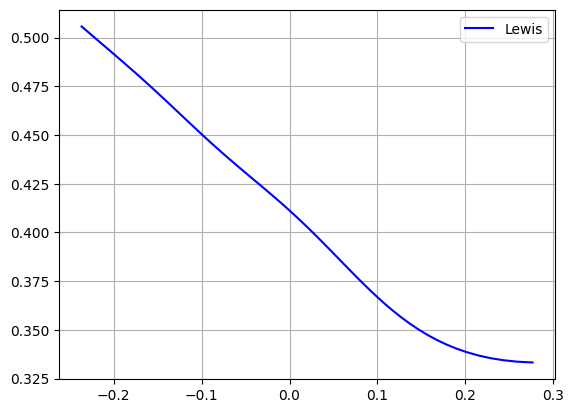

In [16]:
%%time
smile_cf = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                 pricing_params=LewisParams(cf_timestep=0.01))

print(smile_cf)

fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf, "b", label="Lewis")
ax.grid()
ax.legend()

In [17]:
%%time

size = 10000

smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_0, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_0, return_accuracy=True)
)

100%|██████████| 100/100 [00:03<00:00, 27.51it/s]

CPU times: total: 4.14 s
Wall time: 7.45 s


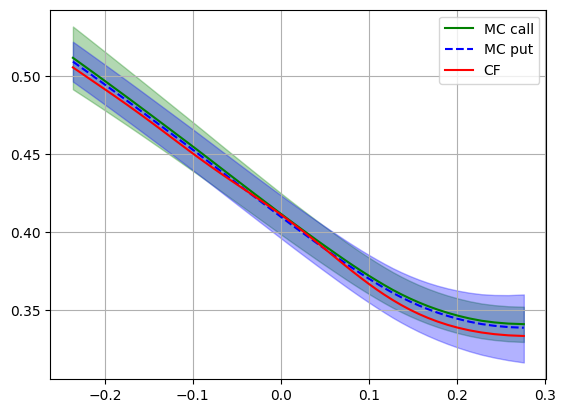

In [18]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.plot(np.log(K / F0), smile_cf, "r", label="CF")
ax.grid()
ax.legend()

## Strict local martingale, $N = 4$, $\rho > 0$

In [4]:
N = 4
rho = 0.9

rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

NameError: name 'leading_coef' is not defined

In [23]:
vol_ts = ta.from_array(trunc=2 * N, array=arr, dim=2)
model = SigVol(vol_ts=vol_ts, rho=rho, shuffle_table=shuffle_table)

In [24]:
ta.print(model.vol_ts)

AttributeError: module 'signature.tensor_algebra' has no attribute 'print'

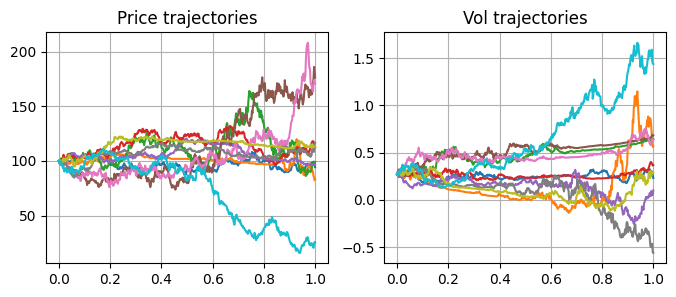

In [25]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [26]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [55]:
%%time
smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=1_000_000, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.13s/it]

CPU times: total: 8min 33s
Wall time: 13min 49s


In [56]:
smile_mc_put - smile_mc_call

array([0.01868648, 0.01800799, 0.01744503, 0.01696887, 0.01656018,
       0.01620553, 0.01589507, 0.01562142, 0.0153789 , 0.01516302,
       0.0149702 , 0.01479752, 0.01464253, 0.01450316, 0.01437768,
       0.0142646 , 0.0141626 , 0.01407057, 0.01398753, 0.01391262,
       0.01384508, 0.01378426, 0.01372958, 0.01368053, 0.01363668,
       0.01359763, 0.01356306, 0.01353265, 0.01350617, 0.01348339,
       0.01346414, 0.01344827, 0.01343566, 0.01342621, 0.01341987,
       0.0134166 , 0.0134164 , 0.01341929, 0.01342535, 0.01343467,
       0.0134474 , 0.01346375, 0.01348399, 0.01350849, 0.01353773,
       0.01357234, 0.01361318, 0.01366141, 0.01371868, 0.01378742])

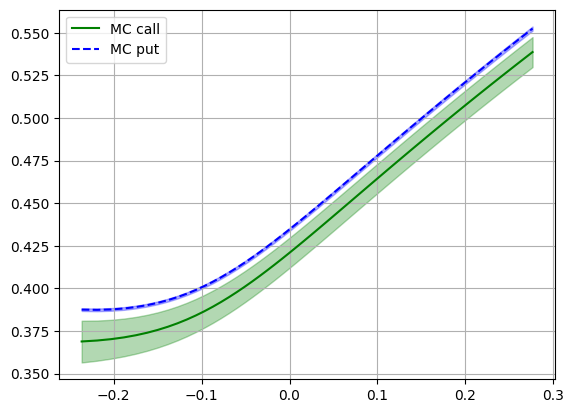

In [57]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [58]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N4_rho_pos' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## Strict local martingale, $N = 5$, $\rho > 0$

In [59]:
N = 5
rho = 0.9


rng = np.random.default_rng(seed=42)

len_arr = 2**(N+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
arr

array([ 0.27, -0.06,  0.36,  0.2 , -0.41,  0.48,  0.26,  0.29, -0.37,
       -0.05, -0.13,  0.43,  0.14,  0.32, -0.06, -0.27,  0.05, -0.44,
        0.33,  0.13,  0.26, -0.15,  0.47,  0.39,  0.28, -0.31, -0.03,
       -0.46, -0.35,  0.18,  0.24,  0.47, -0.17, -0.13, -0.03, -0.31,
       -0.37, -0.02, -0.27,  0.17, -0.06,  0.33,  0.2 , -0.19,  0.33,
        0.3 , -0.11, -0.21,  0.18, -0.36, -0.3 , -0.49,  0.29,  0.16,
        0.21,  0.28, -0.04,  0.07, -0.36, -0.39,  0.17, -0.03,  0.  ])

In [60]:
vol_ts = ta.from_array(trunc=2 * N, array=arr, dim=2)
model = SigVol(vol_ts=vol_ts, rho=rho, shuffle_table=shuffle_table)

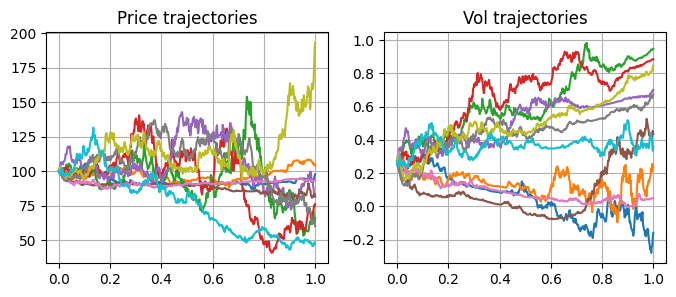

In [62]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")
ax[0].grid()
ax[1].grid()

In [63]:
K = from_1_delta_call_to_strike(deltas = np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.2, ttm=T)
option_call = VanillaOption(T=T, K=K, flag="call")
option_put = VanillaOption(T=T, K=K, flag="put")

In [64]:
%%time

size = 10**6

smile_mc_call, mc_call_lower, mc_call_upper = option_call.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

smile_mc_put, mc_put_lower, mc_put_upper = option_put.get_price(
    model=model, method="mc", F0=F0, is_vol_surface=True, 
    pricing_params=MCParams(size=size, batch_size=10_000, return_accuracy=True)
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [13:56<00:00,  8.37s/it]

CPU times: total: 14min 28s
Wall time: 27min 38s


In [65]:
smile_mc_put - smile_mc_call

array([0.04456123, 0.04287548, 0.04148536, 0.04031526, 0.03931479,
       0.03844931, 0.0376936 , 0.03702892, 0.03644093, 0.03591839,
       0.03545232, 0.03503542, 0.03466167, 0.03432602, 0.03402417,
       0.03375246, 0.03350775, 0.03328728, 0.03308866, 0.03290981,
       0.03274889, 0.03260431, 0.03247465, 0.03235868, 0.03225531,
       0.03216361, 0.03208275, 0.032012  , 0.03195075, 0.03189847,
       0.03185473, 0.03181913, 0.0317914 , 0.0317713 , 0.03175867,
       0.03175344, 0.03175558, 0.03176515, 0.03178229, 0.03180725,
       0.03184037, 0.03188215, 0.03193322, 0.03199444, 0.03206697,
       0.0321523 , 0.03225242, 0.0323701 , 0.03250921, 0.03267543])

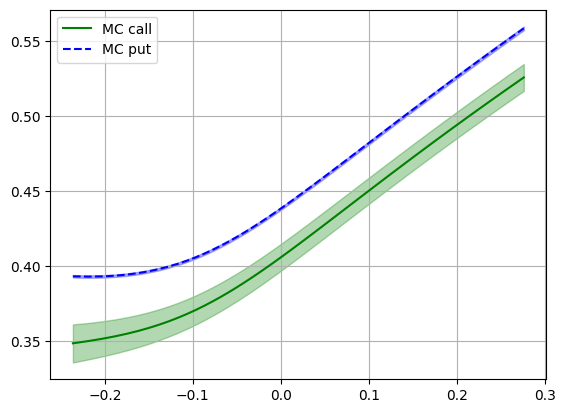

In [66]:
smile_mc_call_local_mart = smile_mc_call
smile_mc_put_local_mart = smile_mc_put

fig, ax = plt.subplots()
ax.plot(np.log(K / F0), smile_mc_call, "g", label="MC call")
ax.fill_between(np.log(K / F0), mc_call_lower, mc_call_upper, color="g", alpha=0.3)
ax.plot(np.log(K / F0), smile_mc_put, "b--", label="MC put")
ax.fill_between(np.log(K / F0), mc_put_lower, mc_put_upper, color="b", alpha=0.3)
ax.grid()
ax.legend()

In [67]:
d = dict()
d["put"] = dict()
d["put"]["price"] = smile_mc_put.tolist()
d["put"]["lower"] = mc_put_lower.tolist()
d["put"]["upper"] = mc_put_upper.tolist()

d["call"] = dict()
d["call"]["price"] = smile_mc_call.tolist()
d["call"]["lower"] = mc_call_lower.tolist()
d["call"]["upper"] = mc_call_upper.tolist()

import json
with open('smiles_N5_rho_pos' + "_lead" + str(leading_coef) + '.json', 'w') as f:
    json.dump(d, f)

## Part 2. Asyptotic behavior of the IV

In [137]:
leading_coef = 1

In [227]:
M = 3

rho1 = -0.
rho2 = -0.9

trunc = M*2

rng = np.random.default_rng(seed=42)

len_arr = 2**(M+1) - 1
arr = np.round(rng.random(len_arr) - 0.5, 2)
arr[-1] = leading_coef
# arr = np.reshape(arr, (-1, 1, 1))
vol_ts = ta.from_array(trunc=trunc, array=arr, dim=2)
vol_ts = ta.from_word(222, trunc, 2)
print(vol_ts)

shuffle_table = ta.get_shuffle_table(table_trunc=trunc, dim=2)

1.0*222


In [228]:
model1 = SigVol(vol_ts=vol_ts, rho=rho1, shuffle_table=shuffle_table)
model2 = SigVol(vol_ts=vol_ts, rho=rho2, shuffle_table=shuffle_table)

model1.vol_ts.trunc

6

In [229]:
T = 1
F0 = 100
k = np.linspace(0, 1, 60)
K = F0 * np.exp(k)

option_call = VanillaOption(T=T, K=K, flag="call")

In [230]:
%%time
smile_cf1 = option_call.get_price(model=model1, method="lewis", F0=F0, is_vol_surface=True,
                                 pricing_params=LewisParams(cf_timestep=0.001))
smile_cf2 = option_call.get_price(model=model2, method="lewis", F0=F0, is_vol_surface=True,
                                 pricing_params=LewisParams(cf_timestep=0.001))

print(smile_cf)

[0.40562305 0.39837202 0.39084309 0.3829797  0.37483558 0.36658936
 0.35851139 0.35089597 0.34398931 0.33794346 0.33280941 0.32856119
 0.32513072 0.32243508 0.32039029 0.31891576 0.31793651 0.3173858
 0.31720649 0.31734971 0.3177723  0.31843578 0.31930728 0.32036014
 0.321572   0.32292165 0.32438793 0.325952   0.32760045 0.32932561
 0.33112241 0.33298447 0.33490188 0.33686046 0.3388426  0.34083218
 0.34282609 0.34484566 0.34693147 0.34911022 0.35134987 0.35354756
 0.35558681 0.35744418 0.35926379 0.36130798 0.36376771 0.36655373
 0.36926432 0.3714087  0.37275524 0.37358474 0.37466702 0.37685946
 0.38046562 0.38486491 0.38880431 0.3910724  0.3910764  0.38921699]
CPU times: total: 15.6 ms
Wall time: 844 ms


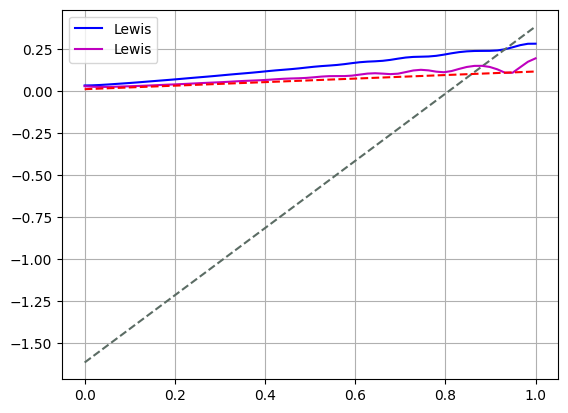

In [231]:
fig, ax = plt.subplots()

ax.plot(np.log(K / F0), smile_cf1**2 * T, "b", label="Lewis")
shift = 5
beta1 = beta_fct(rho1)
ax.plot(k, (k - (k[-shift] - k[0])) * beta1 + (smile_cf1**2 * T)[-shift], "--", color=green)

ax.plot(np.log(K / F0), smile_cf2**2 * T, "m", label="Lewis")
beta2 = beta_fct(rho2)
ax.plot(k, (k - (k[-shift] - k[0])) * beta2 + (smile_cf2**2 * T)[-shift], "--", color="r")
ax.grid()
ax.legend()

In [278]:
from simulation.diffusion import Diffusion
from scipy.stats import norm

t_grid = np.linspace(0, T, 300)
diffusion = Diffusion(t_grid=t_grid, size=10**6, rng=np.random.default_rng(seed=42))
W = diffusion.brownian_motion().squeeze()

In [304]:
total_vol = np.sqrt(np.mean(W**16, axis=1) * T)[:, None]

In [305]:
k = np.linspace(0, 700, 100)
K = F0 * np.exp(k)
call = F0 * norm.cdf(-k / total_vol + 0.5 * total_vol) - K * norm.cdf(-k / total_vol - 0.5 * total_vol)
call = np.mean(call, axis=0)

1.916042161784976


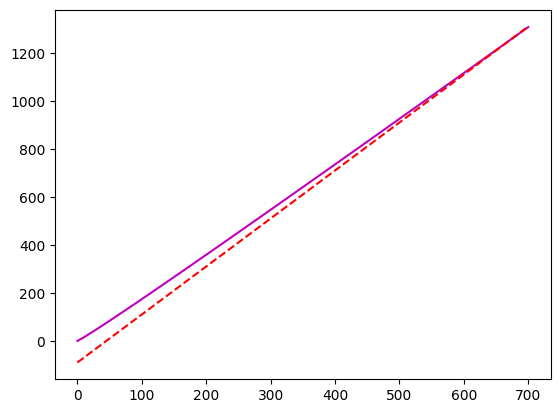

In [306]:
smile = black_iv(option_price=call, T=T, K=K, F=F0, r=0, flag=option_call.flag).squeeze()
plt.plot(k, smile ** 2 * T, "m")
# plt.plot(np.log(K / F0), smile_cf1**2 * T, "b", label="Lewis")
plt.plot(k, (k - (k[-shift] - k[0])) * 2 + (smile**2 * T)[-shift], "--", color="r")

print(((smile**2 * T)[-1] - (smile**2 * T)[-2]) / (k[-1] - k[-2]))

In [207]:
%%time

size = 10**6

mc_call1, mc_call_lower1, mc_call_upper1 = option_call.get_price(
    model=model1, method="mc", F0=F0, is_vol_surface=False,
    pricing_params=MCParams(size=size, batch_size=1_000, return_accuracy=True, timestep=0.0005)
)

100%|██████████| 1000/1000 [13:56<00:00,  1.20it/s]

CPU times: total: 8min 25s
Wall time: 13min 56s


In [208]:
%%time

size = 10**6

mc_call2, mc_call_lower2, mc_call_upper2 = option_call.get_price(
    model=model2, method="mc", F0=F0, is_vol_surface=False,
    pricing_params=MCParams(size=size, batch_size=1_000, return_accuracy=True, timestep=0.0005)
)

100%|██████████| 1000/1000 [13:24<00:00,  1.24it/s]

CPU times: total: 8min 34s
Wall time: 13min 24s


In [211]:
from pricing.volatility_surface.volatility_surface import black_iv

smile_mc_call1 = black_iv(option_price=mc_call1, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()
# smile_mc_call_lower1 = black_iv(option_price=mc_call_lower1, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()
smile_mc_call_upper1 = black_iv(option_price=mc_call_upper1, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()

smile_mc_call2 = black_iv(option_price=mc_call2, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()
# smile_mc_call_lower2 = black_iv(option_price=mc_call_lower2, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()
smile_mc_call_upper2 = black_iv(option_price=mc_call_upper2, T=option_call.T, K=option_call.K, F=F0, r=0, flag=option_call.flag).squeeze()

In [212]:
beta_fct = lambda x: 2 * (1 - np.abs(x)) / (1 + np.abs(x))
beta1 = beta_fct(rho1)
beta2 = beta_fct(rho2)

beta1, beta2

(9.999999722180686e-10, 0.10526315789473682)

Text(0.5, 0, '$\\log(K / S_0)$')

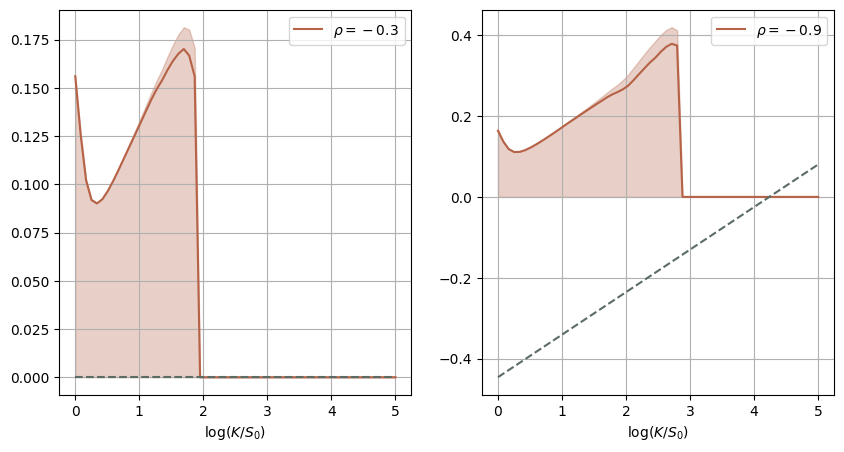

In [218]:
# smile_mc_call_local_mart = smile_mc_call
# smile_mc_put_local_mart = smile_mc_put
shift = 10

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(k, smile_mc_call1**2 * T, color=copper, label=r"$\rho = -0.3$")
# ax.plot(k, smile_cf**2 * T, color=copper, label="Lewis")
ax[0].fill_between(k, 0 * smile_mc_call_lower1**2 * T, smile_mc_call_upper1**2 * T, color=copper, alpha=0.3)
ax[0].plot(k, (k - (k[-shift] - k[0])) * beta1 + (smile_mc_call1**2 * T)[-shift], "--", color=green)

ax[1].plot(k, smile_mc_call2**2 * T, color=copper, label=r"$\rho = -0.9$")
# # ax.plot(k, smile_cf**2 * T, color=copper, label="Lewis")
ax[1].fill_between(k, 0*smile_mc_call_lower2**2 * T, smile_mc_call_upper2**2 * T, color=copper, alpha=0.3)
ax[1].plot(k, (k - (k[-shift] - k[0])) * beta2 + (smile_mc_call2**2 * T)[-shift], "--", color=green)

# ax[1].plot(k, 0 * smile_mc_call1**2 * T, color="m", label=r"$\rho = -0.3$")
# # ax.plot(k, smile_cf**2 * T, color=copper, label="Lewis")
# # ax.fill_between(k, smile_mc_call_lower1**2 * T, smile_mc_call_upper1**2 * T, color=copper, alpha=0.3)
# ax[1].plot(k, (k - (k[-shift] - k[0])) * beta1 + (smile_mc_call1**2 * T)[-shift], "--", color=green)


ax[0].grid()
ax[0].legend()
# ax.set_ylim([0.07, 0.18])
ax[0].set_xlabel("$\log(K / S_0)$")

ax[1].grid()
ax[1].legend()
# ax.set_ylim([0.07, 0.18])
ax[1].set_xlabel("$\log(K / S_0)$")

# fig.savefig("iv_asymp_N=5_rho=-09.pdf", format="pdf", transparent=True)

In [255]:
# smile_mc_call_09 = smile_mc_call
# smile_mc_call_lower_09 = smile_mc_call_lower
# smile_mc_call_upper_09 = smile_mc_call_upper
# beta_09 = beta

calculate for different rhos